## Time Nyx vs LaCE emulators


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.emulator import p1d_archive_Nyx
from lace_manager.data import data_MPGADGET
from lace_manager.likelihood import likelihood
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label="central",
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [3]:
# Set up emulator training set
lace_archive=p1d_archive.archiveP1D(basedir=basedir,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)

In [4]:
t0=time.time()
nyx_fname='/Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5'
nyx_archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=nyx_fname,verbosity=1)
t1=time.time()
print('spent {:.3f} seconds reading Nyx archive'.format(t1-t0))

will read Nyx file /Users/font/Projects/LaCE_manager/lace_manager/emulator/sim_suites/test_nyx/large_nyx_models.hdf5
number of samples 14
parameter names ['A_UVB', 'A_lya', 'A_s', 'H_0', 'Omega_m', 'h', 'n_lya', 'n_s', 'omega_m', 'sigma8']
will use redshift grid [2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 5.0, 5.4]
thermal grid ['thermal_grid_0', 'thermal_grid_1', 'thermal_grid_10', 'thermal_grid_11', 'thermal_grid_12', 'thermal_grid_13', 'thermal_grid_14', 'thermal_grid_2', 'thermal_grid_3', 'thermal_grid_4', 'thermal_grid_5', 'thermal_grid_6', 'thermal_grid_7', 'thermal_grid_8', 'thermal_grid_9']
archive setup, containing 3150 entries
spent 93.893 seconds reading Nyx archive


In [5]:
kmax_Mpc=8
lace_emu=gp_emulator.GPEmulator(basedir,z_max=z_max,verbose=False,train=True,
                                paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p'],
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=lace_archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.42 seconds


In [6]:
t0=time.time()
nyx_emu=gp_emulator.GPEmulator(basedir,z_max=z_max,verbose=False,train=True,
                                paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p'],
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=nyx_archive,
                                kmax_Mpc=kmax_Mpc)
t1=time.time()
print('spent {:.3f} seconds training Nyx emulator'.format(t1-t0))

Training GP on 3150 points
GPs optimised in 107.60 seconds
spent 108.193 seconds training Nyx emulator


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
#free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1"]
free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_gamma_0"]
prior=0.2

In [8]:
t0=time.time()
lace_like=likelihood.Likelihood(data=data,emulator=lace_emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
t1=time.time()
print('spent {:.3f} seconds setting up LaCE likelihood'.format(t1-t0))

spent 1.500 seconds setting up LaCE likelihood


In [9]:
t0=time.time()
nyx_like=likelihood.Likelihood(data=data,emulator=nyx_emu,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
t1=time.time()
print('spent {:.3f} seconds setting up Nyx likelihood'.format(t1-t0))

spent 1.419 seconds setting up Nyx likelihood


In [10]:
lace_like.get_log_like()

-19.53524925456794

In [11]:
nyx_like.get_log_like()

-876.2271553033476

In [12]:
for like in [lace_like,nyx_like]:
    t0=time.time()
    Nit=40
    for it in range(Nit):
        like.get_log_like(values=[0.5]*len(like.free_params))
    t1=time.time()
    print('spent {:.3f} seconds per likelihood evaluation'.format((t1-t0)/Nit))

spent 0.026 seconds per likelihood evaluation
spent 0.077 seconds per likelihood evaluation


will run migrad
will compute Hessian matrix
best-fit values = [0.4590996  0.47637948 0.50631877 0.5045017  0.49969904 0.49428124]


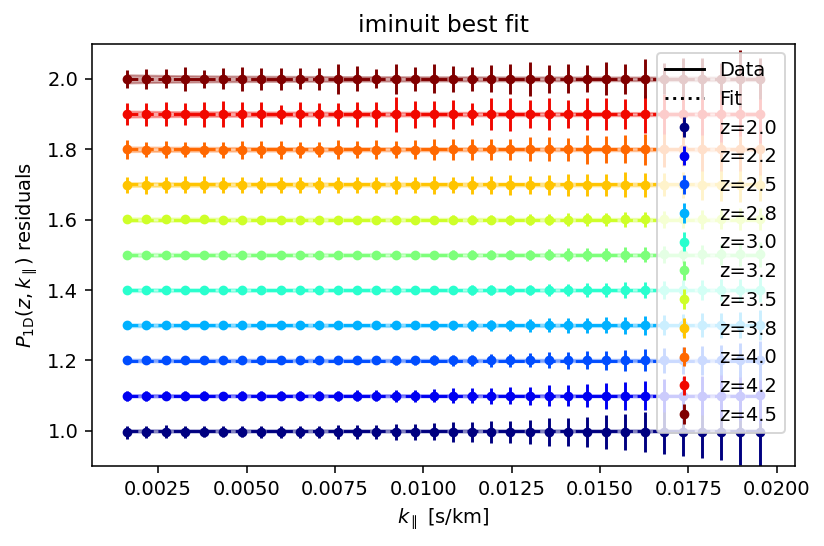

spent 9.135 seconds to maximize LaCE likelihood


In [13]:
t0=time.time()
lace_minimizer=iminuit_minimizer.IminuitMinimizer(lace_like)
lace_minimizer.minimize(compute_hesse=True)
lace_minimizer.plot_best_fit()
t1=time.time()
print('spent {:.3f} seconds to maximize LaCE likelihood'.format(t1-t0))

compute true values for As ns


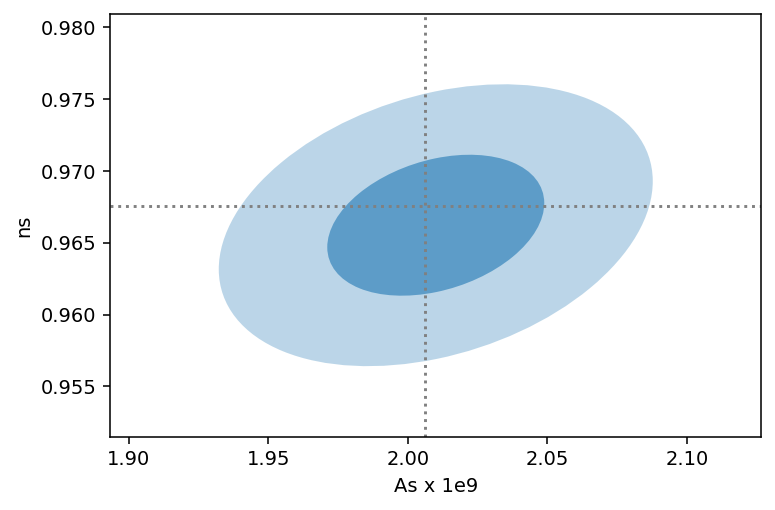

In [14]:
lace_minimizer.plot_ellipses('As','ns')

will run migrad
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 5.01234e+206 Requested 0.0001
W MnGlobalCorrelationCoeff inversion of matrix fails
will compute Hessian matrix
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00687414
best-fit values = [0.47966271 0.53821558 0.97194902 0.34883598 0.33444692 0.99997372]


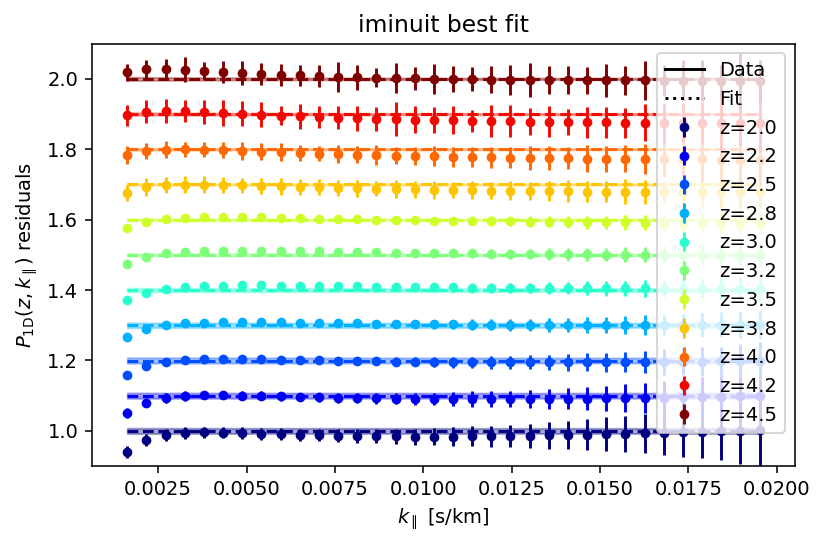

spent 46.211 seconds to maximize Nyx likelihood


In [15]:
t0=time.time()
nyx_minimizer=iminuit_minimizer.IminuitMinimizer(nyx_like)
nyx_minimizer.minimize(compute_hesse=True)
nyx_minimizer.plot_best_fit()
t1=time.time()
print('spent {:.3f} seconds to maximize Nyx likelihood'.format(t1-t0))

compute true values for As ns


(2.0, 2.2)

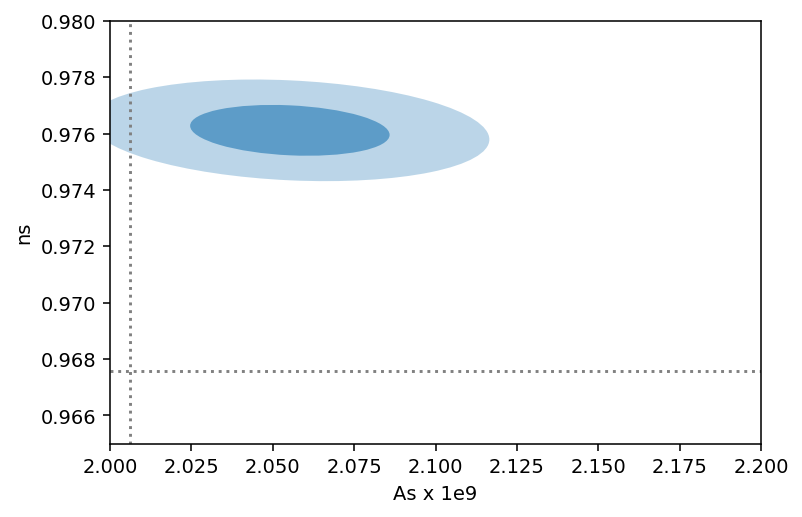

In [16]:
nyx_minimizer.plot_ellipses('As','ns')
plt.ylim(0.965,0.98)
plt.xlim(2.0,2.2)